In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [27]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
#train_df = pd.read_csv("./train.csv")
#test_df = pd.read_csv("./test.csv")
#submit_df = pd.read_csv("./submit_sample.csv", header=None)

train_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/test.csv")
submit_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/signate/submit_sample.csv", header=None)

In [10]:
train_df.shape, test_df.shape, submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

In [11]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


<BarContainer object of 42 artists>

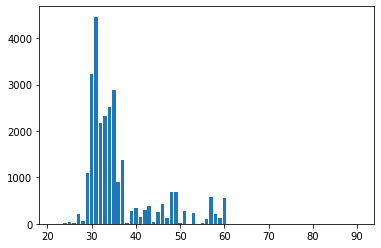

In [21]:
plt.bar(train_df['age'].value_counts().sort_index().index, train_df['age'].value_counts().sort_index())

In [79]:
period = range(0, 120, 10)

# index : age (pandas Series obj)
#print(target_df["age"])
# the number of "y" in each colmun (numpy Array)
#print(np.array(target_df['y']) * np.array(train_df['age'].value_counts().sort_index()))
# list of age
#print(train_df['age'].value_counts().sort_index().index)

list_age = train_df['age'].value_counts().sort_index().index
target_df = train_df.groupby(['age'], as_index=False).mean()
sum_y = np.array(target_df['y']) * np.array(train_df['age'].value_counts().sort_index())

######################
# whileの中ではtarget_df["age"]のindexとageを使って処理


prob = np.zeros(int(list_age[-1]/10)+1)
index = 0
for lim_age in period:
  num_people = 0
  print("############# ", lim_age)
  print("#############################")
  while lim_age > index:
    print(np.array(train_df['age'].value_counts().sort_index())[index])
    if index >= len(sum_y):
      break
    num_people += np.array(train_df['age'].value_counts().sort_index())[index]
    prob[int(lim_age/10)] += sum_y[index]
    index += 1
  if (max(list_age) > index) and (num_people != 0):
    print(num_people)
    prob[int(lim_age/10)] /= num_people

print(prob, train_df['age'].value_counts().sort_index())
plt.bar(prob, train_df['age'].value_counts().sort_index())

#############  0.0
#############################
#############  1.0
#############################
1
8
35
10
222
66
1104
3226
4464
2176
11312
#############  2.0
#############################
2318
2521
2888
907
1368
12
270
333
153
307
11077
#############  3.0
#############################
385
39
252
435
115
675
683
18
279
5
2886
#############  4.0
#############################
236
4
11
104
573
222
116
546
6
1
1819
#############  5.0
#############################
1
5


IndexError: ignored

<BarContainer object of 11 artists>

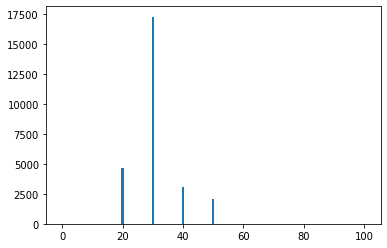

In [58]:
age_list = range(0, 120, 10)
age_ctgr = pd.cut(train_df['age'], bins=age_list)

plot_data = age_ctgr.value_counts().sort_index()
plt.bar(range(0, 110, 10), plot_data)

In [ ]:
all_df = pd.concat([train_df, test_df])
del train_df, test_df
gc.collect()

81

In [ ]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col] = lbl.transform(all_df[col])

In [ ]:
train_df = all_df[all_df['y']!=-999]
test_df = all_df[all_df['y']==-999]

In [ ]:
y_train = train_df['y']
X_train = train_df.drop(['y', 'id'], axis=1)
X_test = test_df.drop(['y', 'id'], axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    "objective":"binary"
}

model = lgb.train(
    params, lgb_train,
    valid_sets = [lgb_train, lgb_eval],
    verbose_eval = 10,
    num_boost_round = 1000,
    early_stopping_rounds=10
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.209427	valid_1's binary_logloss: 0.219289
[20]	training's binary_logloss: 0.191038	valid_1's binary_logloss: 0.209227
[30]	training's binary_logloss: 0.178925	valid_1's binary_logloss: 0.204428
[40]	training's binary_logloss: 0.169569	valid_1's binary_logloss: 0.203095
[50]	training's binary_logloss: 0.161995	valid_1's binary_logloss: 0.20335
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.163581	valid_1's binary_logloss: 0.203038


In [ ]:
y_pred

array([0.78074173, 0.07075874, 0.02624937, ..., 0.06533223, 0.0072316 ,
       0.13983576])

In [ ]:
submit_df[1] = y_pred

In [ ]:
submit_df.to_csv('./submit.csv', index=False, header=None)